<a href="https://colab.research.google.com/github/apallath/fashion_mnist_models/blob/main/fashion_mnist_cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.backend import random_normal

from tensorflow.keras.datasets import fashion_mnist

In [18]:
class SamplingLayer(layers.Layer):
    """
    Sampling layer that implements the VAE reparameterization trick.
    
    See keras base Layer class doc for details.
    """

    def call(self, inputs):
        """Performs sampling given mean and log variance of the latent space."""
        z_mean = inputs[0]
        z_log_var = inputs[1]

        # Get batch size
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        
        # Sample epsilon from normal distribution
        epsilon = random_normal(shape=(batch_size, latent_dim))

        # Reparameterization trick
        return z_mean + tf.exp(z_log_var) * epsilon


class ImageVAE(tf.keras.Model):
    """
    Base VAE model for image data.

    Subclass and implement get_encoder and get_decoder methods to use.

    Args:
        latent_dim (int): Dimension of the latent space.
        bce_reconst_loss (bool): Use BCE reconstruction loss instead of MSE reconstruction loss (default = True).
    """
    def __init__(self, latent_dim: int = 2, bce_reconst_loss=True, **kwargs):
        super(ImageVAE, self).__init__(**kwargs)

        self.bce_reconst_loss = bce_reconst_loss

        # Get encoder and decoder Models
        self.encoder = self.get_encoder(latent_dim)
        self.decoder = self.get_decoder(latent_dim)

        # Metrics to track during model training
        self.total_loss_metric = metrics.Mean(name="total_loss")
        self.reconstruction_loss_metric = metrics.Mean(name="reconstruction_loss")
        self.KLD_loss_metric = metrics.Mean(name="KLD_loss")

    @property
    def metrics(self):
        return [self.total_loss_metric,
                self.reconstruction_loss_metric,
                self.KLD_loss_metric]

    def train_step(self, data):
        """Custom training step in Model.fit()
        
        See doc at https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit"""

        # track operations within this context
        # as network is trainable, these variables are automatically being watched
        # see tf.GradientTape doc for more details
        with tf.GradientTape() as g:
            z_mean, z_log_var, z = self.encoder(data)
            reconst = self.decoder(z)

            # reconstruction loss
            # sum losses over channels; and compute mean over batches
            if self.bce_reconst_loss:
                # compute BCE loss
                reconst_loss = tf.reduce_mean(
                    tf.reduce_sum(losses.binary_crossentropy(data, reconst), axis=(1, 2))  
                )
            else:
                # compute MSE loss
                reconst_loss = tf.reduce_mean(
                    tf.reduce_sum(losses.mean_squared_error(data, reconst), axis=(1, 2))
                )

            # KLD loss
            # L_latent = -1/2 sum_{j=1}^{J} (1 + log(varz_j^2) - meanz_j^2 - varz_j^2)
            # where J is the dimension
            # Take mean of loss over batch 
            KLD_loss = tf.reduce_mean(
                -0.5 * tf.reduce_sum(1 + (2 * z_log_var) - tf.square(z_mean) - tf.exp(2 * z_log_var), axis=1)
            )

            # Total loss = sum of both losses
            total_loss = reconst_loss + KLD_loss

        # compute gradient of loss w.r.t all trainable weights using backprop
        grads = g.gradient(total_loss, self.trainable_weights)

        # ask the optimizer to apply the gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # update metrics
        self.reconstruction_loss_metric.update_state(reconst_loss)
        self.KLD_loss_metric.update_state(KLD_loss)
        self.total_loss_metric.update_state(total_loss)

        # return dict mapping metric names to current value
        return {"reconstruction_loss": self.total_loss_metric.result(),
                "KLD_loss": self.KLD_loss_metric.result(),
                "total_loss": self.total_loss_metric.result()}
    
    @classmethod
    def get_encoder(self, latent_dim):
        raise NotImplementedError()

    @classmethod
    def get_decoder(self, latent_dim):
        raise NotImplementedError() 

In [19]:
class Fashion_MNIST_CVAE(ImageVAE):
    @classmethod
    def get_encoder(self, latent_dim):
        inputs = tf.keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(inputs)
        x = layers.Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation='relu')(x)

        # Outputs
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = SamplingLayer()([z_mean, z_log_var])

        encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
        return encoder

    @classmethod
    def get_decoder(self, latent_dim):
        inputs = tf.keras.Input(shape=(latent_dim,))
        x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
        x = layers.Reshape((7, 7, 64))(x)
        x = layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, activation='relu', padding="same")(x)
        x = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, activation='relu', padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

        decoder = tf.keras.Model(inputs, decoder_outputs, name="decoder")
        return decoder

In [5]:
test_encoder = Fashion_MNIST_CVAE.get_encoder(2)
print(test_encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
test_decoder = Fashion_MNIST_CVAE.get_decoder(2)
print(test_decoder.summary())

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

# BCE Reconstruction Loss

## Training

In [7]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
all_data = np.concatenate([x_train, x_test])
all_data = np.expand_dims(all_data, -1).astype("float32") / 255

cvae = Fashion_MNIST_CVAE(2)
cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = cvae.fit(all_data, epochs=30, batch_size=128)

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 13s 10ms/step - reconstruction_loss: 343.3961 - KLD_loss: 6.4663 - total_loss: 343.3961
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 281.2542 - KLD_loss: 8.3051 - total_loss: 281.2542
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 274.5116 - KLD_loss: 7.2926 - total_loss: 274.5116
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 271.6907 - KLD_loss: 7.0162 - total_loss: 271.6907
Epoch 5/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 269.8625 - KLD_loss: 6.9522 - total_loss: 269.8625
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 268.7750 - KLD_loss: 6.8888 - total_loss: 268.7750
Epoch 7/30
547/547 [==============================] - 5s 10ms/step - reconstruction_loss: 267.7

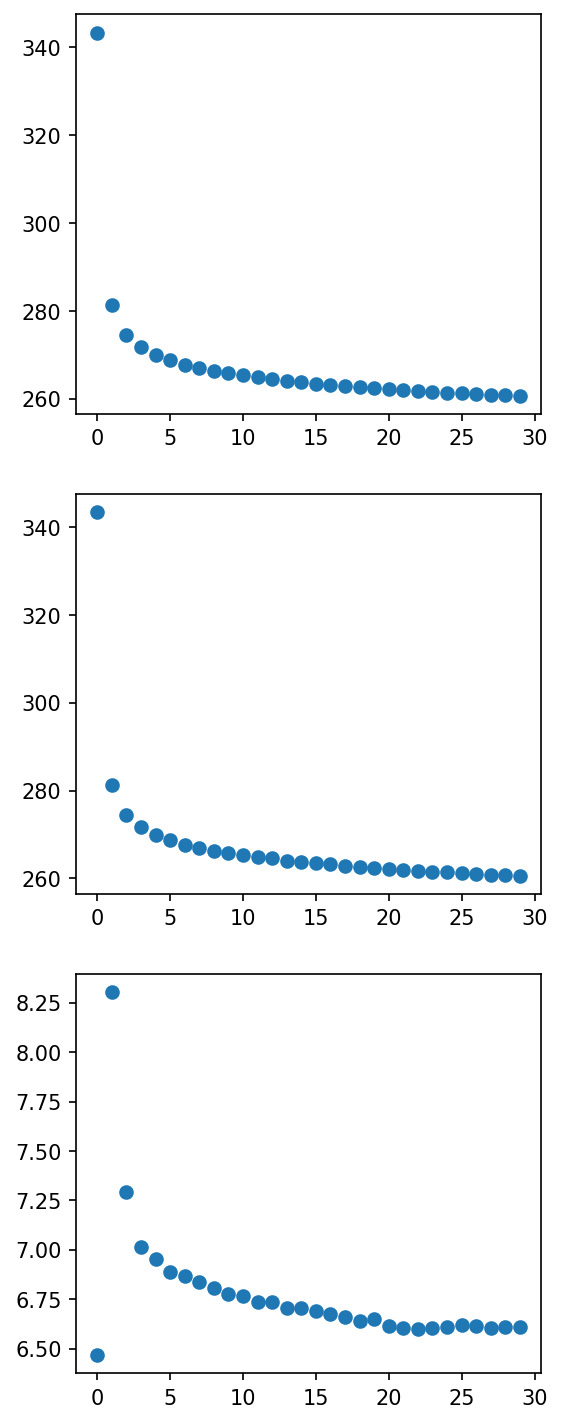

In [8]:
v

 ## Visualizing Decoder

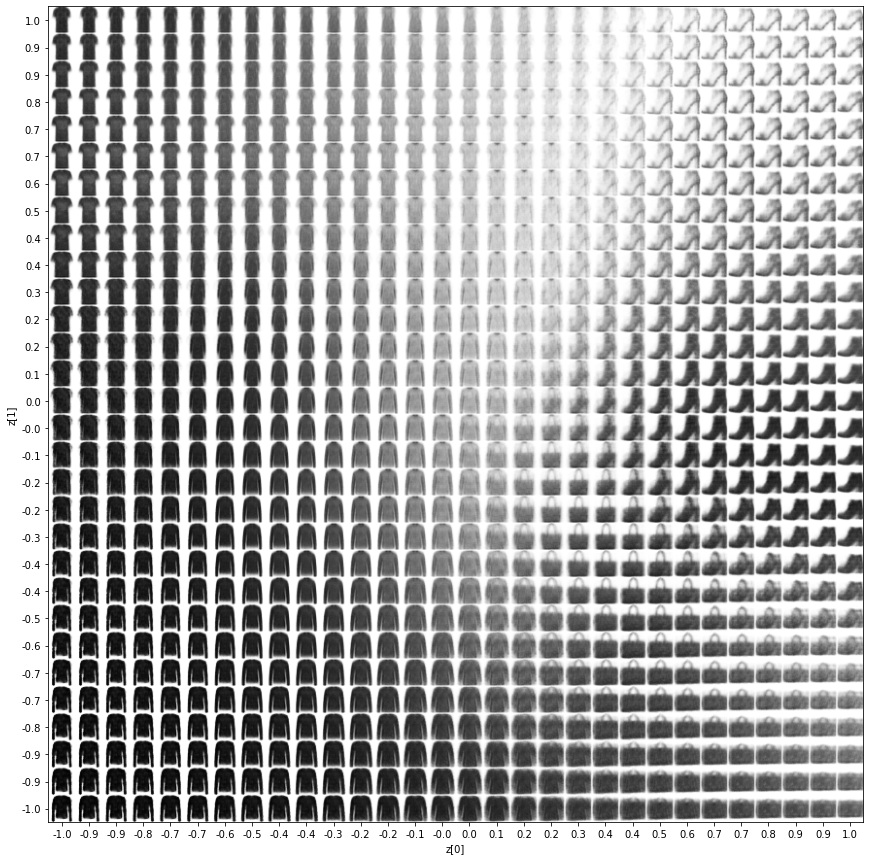

In [10]:
def visualize_2LD_decoder(cvae, grid_size=(30, 30), image_size=(28, 28), figsize=(15, 15)):
    # Canvas for figure
    figure = np.zeros((image_size[0] * grid_size[0], image_size[1] * grid_size[1]))

    # Change latent dimensions linearly
    grid_x = np.linspace(-1, 1, 30)
    grid_y = np.linspace(-1, 1, 30)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = cvae.decoder.predict(z_sample)
            image = x_decoded[0].reshape(image_size)
            figure[
                i * image_size[0] : (i + 1) * image_size[0],
                j * image_size[1] : (j + 1) * image_size[1],
            ] = image

    plt.figure(figsize=figsize)

    start_range_x = image_size[0] // 2
    end_range_x = grid_size[0] * image_size[0] + start_range_x

    start_range_y = image_size[1] // 2
    end_range_y = grid_size[1] * image_size[1] + start_range_y

    pixel_range_x = np.arange(start_range_x, end_range_x, image_size[0])
    pixel_range_y = np.arange(start_range_y, end_range_y, image_size[1])

    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range_x, sample_range_x)
    plt.yticks(pixel_range_y, sample_range_y)

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray_r")
    plt.show()

visualize_2LD_decoder(cvae)

## Visualizing Latent Space Mapping

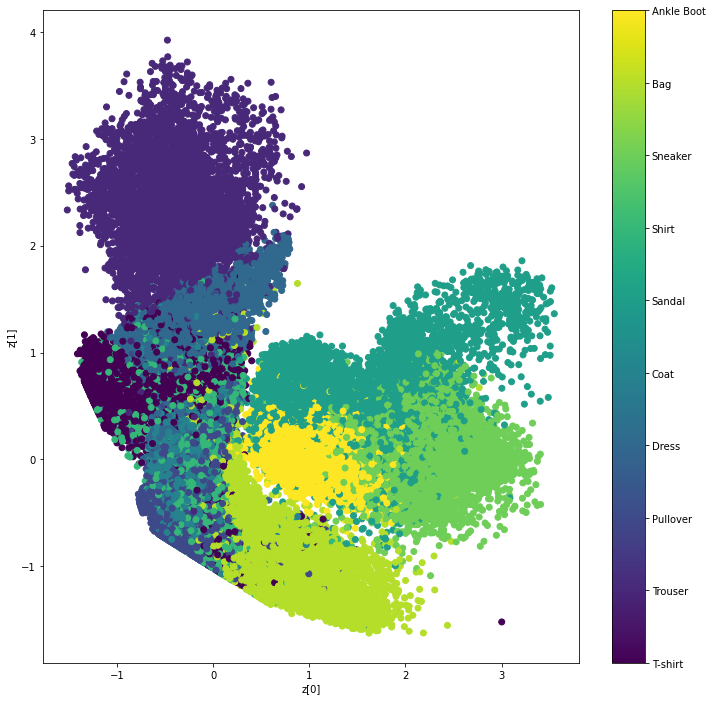

In [16]:
def visualize_latent_space(cvae, data, labels):
    z_mean, _, _ = cvae.encoder.predict(data)
    plt.figure(figsize=(12, 12))

    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cbar.ax.set_yticklabels(['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'])

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
visualize_latent_space(cvae, x_train, y_train)

# MSE Reconstruction Loss

In [20]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
all_data = np.concatenate([x_train, x_test])
all_data = np.expand_dims(all_data, -1).astype("float32") / 255

cvae = Fashion_MNIST_CVAE(2, bce_reconst_loss=False)
cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = cvae.fit(all_data, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 6s 9ms/step - reconstruction_loss: 56.9713 - KLD_loss: 2.7166 - total_loss: 56.9713
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 36.6777 - KLD_loss: 4.8078 - total_loss: 36.6777
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 33.4092 - KLD_loss: 5.0434 - total_loss: 33.4092
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 32.1973 - KLD_loss: 5.0378 - total_loss: 32.1973
Epoch 5/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 31.5995 - KLD_loss: 5.0118 - total_loss: 31.5995
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 31.0890 - KLD_loss: 4.9822 - total_loss: 31.0890
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - reconstruction_loss: 30.6897 - KLD_loss: 4.9807 - total_loss: 30.6897
Epoch 8/30
547/547 [==============

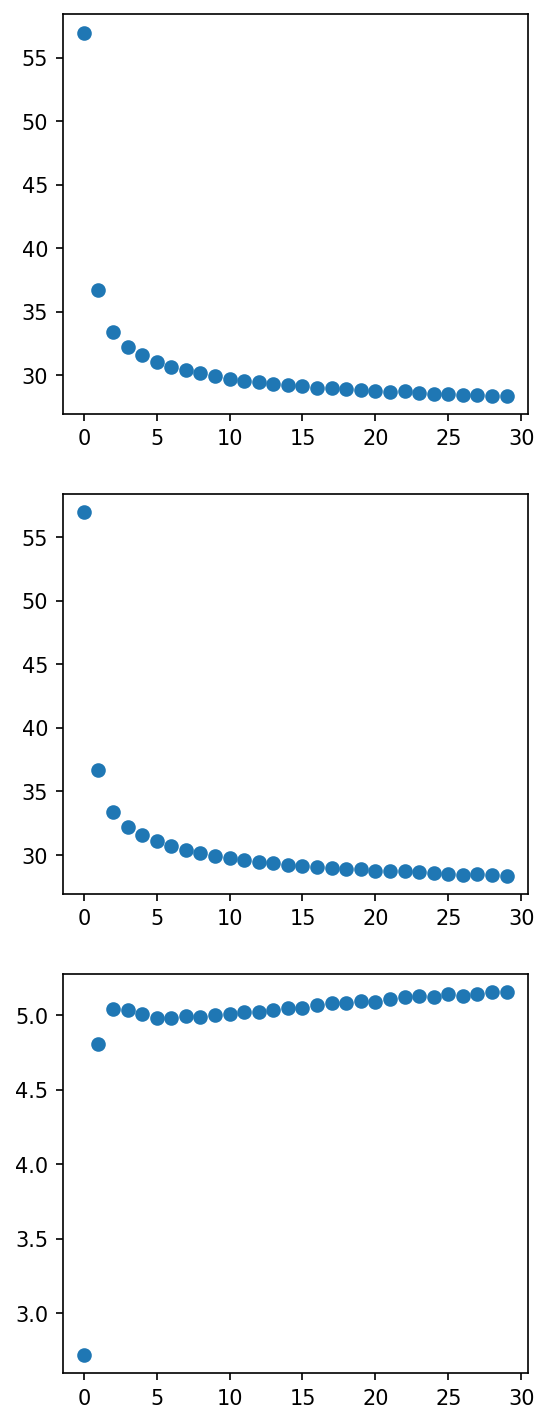

In [21]:
n_epochs = 30

fig, ax = plt.subplots(3, 1, figsize=(4,12), dpi=150)
ax[0].plot(range(n_epochs), history.history['total_loss'], 'o')
ax[1].plot(range(n_epochs), history.history['reconstruction_loss'], 'o')
ax[2].plot(range(n_epochs), history.history['KLD_loss'], 'o')

 ## Visualizing Decoder

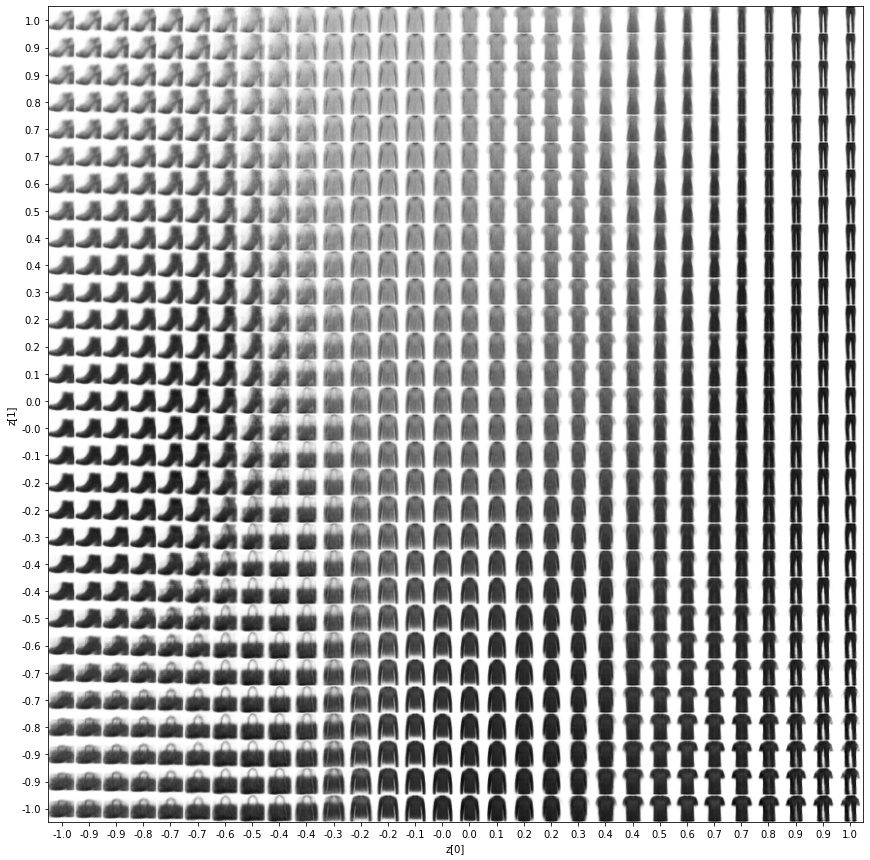

In [22]:
def visualize_2LD_decoder(cvae, grid_size=(30, 30), image_size=(28, 28), figsize=(15, 15)):
    # Canvas for figure
    figure = np.zeros((image_size[0] * grid_size[0], image_size[1] * grid_size[1]))

    # Change latent dimensions linearly
    grid_x = np.linspace(-1, 1, 30)
    grid_y = np.linspace(-1, 1, 30)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = cvae.decoder.predict(z_sample)
            image = x_decoded[0].reshape(image_size)
            figure[
                i * image_size[0] : (i + 1) * image_size[0],
                j * image_size[1] : (j + 1) * image_size[1],
            ] = image

    plt.figure(figsize=figsize)

    start_range_x = image_size[0] // 2
    end_range_x = grid_size[0] * image_size[0] + start_range_x

    start_range_y = image_size[1] // 2
    end_range_y = grid_size[1] * image_size[1] + start_range_y

    pixel_range_x = np.arange(start_range_x, end_range_x, image_size[0])
    pixel_range_y = np.arange(start_range_y, end_range_y, image_size[1])

    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range_x, sample_range_x)
    plt.yticks(pixel_range_y, sample_range_y)

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray_r")
    plt.show()

visualize_2LD_decoder(cvae)

 ## Visualizing Latent Space Mapping

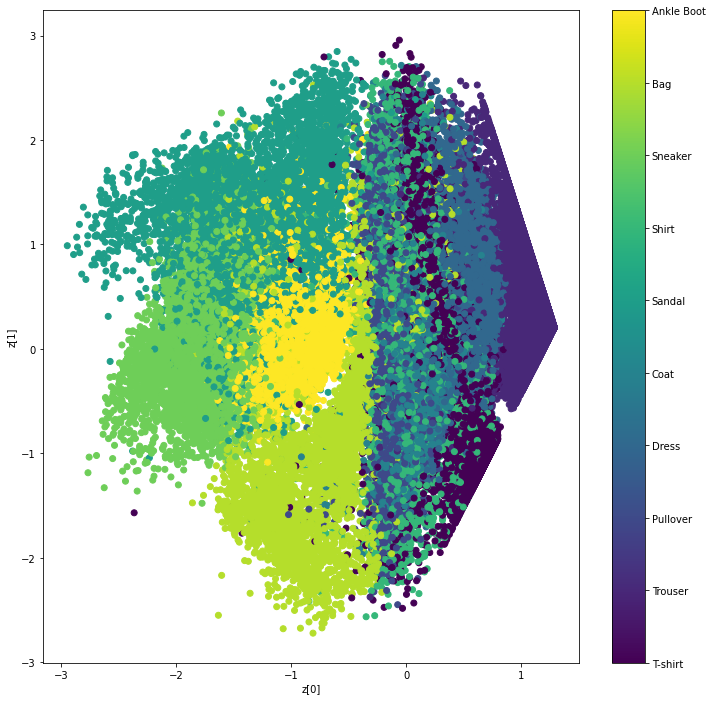

In [23]:
def visualize_latent_space(cvae, data, labels):
    z_mean, _, _ = cvae.encoder.predict(data)
    plt.figure(figsize=(12, 12))

    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cbar.ax.set_yticklabels(['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'])

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
visualize_latent_space(cvae, x_train, y_train)